In [1]:
import numpy.random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorboard
# import keras
import matplotlib as plt
import os


class Env:

    def __init__(self):  # initialize the env
        # env variables
        self.finishTime = 18.50
        self.beginTime = 10.01
        self.trainTime = 5
        self.budgetState = [100, 0]
        self.executionFee = 4 / 10 ** 4
        self.stateSpaceStDict = dict()
        self.stateSpaceLtDict = dict()
        self.LtStepSize = 300
        self.StStepSize = 3000
        self.step2 = 0
        self.reward_range = [0]



        df = pd.read_csv("shortTerm5min.csv", sep=",")
        df.drop('<TICKER>', inplace=True, axis=1)
        df.drop('<PER>', inplace=True, axis=1)
        df.dropna()
        dateDf = df[['<DATE>']]
        timeDf = df[['<TIME>']]
        df.drop('<DATE>', inplace=True, axis=1)
        df.drop('<TIME>', inplace=True, axis=1)

        for i in range(len(dateDf)):
            date = dateDf.iloc[i]
            time = timeDf.iloc[i]

            if date[0] > 20200110:  # skip the first date since no data is present earlier to process
                self.stateSpaceStDict[(date[0], time[0])] = df.iloc[i - 105: i].copy(deep=True).reset_index()

        df1 = pd.read_csv("longTermData.csv", sep=",")
        df1.drop('<TICKER>', inplace=True, axis=1)
        df1.drop('<PER>', inplace=True, axis=1)
        # df1.dropna()
        dateDf1 = df1[['<DATE>']]
        timeDf1 = df1[['<TIME>']]
        df1.drop('<DATE>', inplace=True, axis=1)
        df1.drop('<TIME>', inplace=True, axis=1)
        for i in range(len(dateDf1)):
            date1 = dateDf1.iloc[i]
            time1 = timeDf1.iloc[i]

            if date1[0] > 20200110:  # skip the first date since no data is present earlier to process
                self.stateSpaceLtDict[(date1[0], time1[0])] = df1.iloc[i - 40: i].copy(deep=True).reset_index()

        # print(self.stateSpaceLt[(20210415, 1500)])
        # normalize the columns of stateSpace

        # save to file
        self.stateSpaceStDict = self.scalePrices(self.stateSpaceStDict)
        self.stateSpaceLtDict = self.scalePrices(self.stateSpaceLtDict)

        self.dateListSt = list(self.stateSpaceStDict)

        self.dateListLt = list(self.stateSpaceLtDict)


        # self.stateSpaceSt.to_Frame().to_save("st", sep=',')



    def getReward(self, oldBudgetState, newBudgetState, action, type):

        #if type == 2:
        #    pass
        #elif type == 3:
        #    pass
        #else:
        return newBudgetState[0] - oldBudgetState[0] + newBudgetState[1] - oldBudgetState[1]
        # type = 0 no intrinsic short term
        # type = 1 no intrinsic long term
        # type = 2 short term model comparison with long term model
        # type = 3 long term model comparison with short term model

    def getInstrinsicReward(self, date, budget, type):
        pass


    def scalePrices(self, stateSpace):
        # normalize columns for each frame stored in stateSpace
        length = len(stateSpace[(20200113, 1500)])
        for key, value in stateSpace.items():
            # extract values to normalize wrt
            # value['<LOW>'][len(value['<LOW>']) - 1]

            openNorm = value.iloc[length - 1]['<OPEN>']

            highNorm = value['<OPEN>'][length - 1]

            volNorm = value['<VOL>'][length - 1]

            for column in value:
                if column == '<VOL>':
                    value[column] = value[column] / volNorm
                elif column == 'index':
                    pass
                else:
                    value[column] = value[column] / openNorm
        print(stateSpace[(20200113, 1500)])
        return stateSpace

    def takeAction(self, budgetState, acts):

        selectedAction = acts[0]
        buyAmount = acts[1]
        hold = acts[2]
        sellAmount = acts[3]
        if (selectedAction == hold): # hold
            return budgetState
        elif (selectedAction == buyAmount):
            return self.buy(budgetState, buyAmount)
        elif (selectedAction == sellAmount):
            return self.sell(budgetState, sellAmount)

    def buy(self, budgetState, percent):
        buyAmount = budgetState[0] * (percent)

        budgetState[0] -= buyAmount * ( 1 + self.executionFee)
        budgetState[1] += buyAmount
        return budgetState

    def sell(self, budgetState, percent):
        sellAmount = budgetState[1] * (percent)
        budgetState[0] += sellAmount * ( 1 - self.executionFee)
        budgetState[1] -= sellAmount
        return budgetState

    def startState(self, type):
        cashBudget = np.random.rand()
        stockBudget = 1 - cashBudget


# before 4089 lt validation , 4089 sonrası validation 20210504 saat 10
        #yine aynı tarih st 476901 bu ve sonrası validation.
        if type == 0 or type == 2:  # short term
            date = self.dateListSt[47601]
            df = self.stateSpaceStDict.get(date)
        else:  # long term
            date = self.dateListLt[4089]
            df = self.stateSpaceLtDict.get(date)

        arrayVersion = [date]
        for index, row in df.iterrows():
            i = 0
            for element in row:
                if i != 0:
                    arrayVersion.append(element)
                i += 1

        arrayVersion += [cashBudget, stockBudget]

        return arrayVersion

    def getNextState(self, date, newBudget, type):
        nextDate = -1
        isDoneFlag = False
        if type == 0 or type == 2:  # short term
            if self.dateListSt.index(date) >= len(self.dateListSt)-2:
                isDoneFlag = True
            nextDate = self.dateListSt[self.dateListSt.index(date) + 1]
            df = self.stateSpaceStDict.get(nextDate)
        else:  # long term
            if self.dateListLt.index(date) >= len(self.dateListLt)-2:
                isDoneFlag = True
            nextDate = self.dateListLt[self.dateListLt.index(date) + 1]
            df = self.stateSpaceLtDict.get(nextDate)

        arrayVersion = [nextDate]
        for index, row in df.iterrows():
            i = 0
            for element in row:
                if i != 0:
                    arrayVersion.append(element)
                i += 1

        newBudget[1] *= 1/arrayVersion[-10]

        arrayVersion += [newBudget[0], newBudget[1]]

        return isDoneFlag, arrayVersion




    def step(self, state, action, type):

        isDone = False
        reward = 0
        self.step2 += 1
        currentDate = state[0]
        oldBudgetState = state[-2:]
        newBudgetState = self.takeAction(oldBudgetState, action)

        isDone, nextState = self.getNextState(currentDate, newBudgetState, type)
        if type%2 == 1:
            if self.step2 % self.LtStepSize == 0:
                isDone = True
        elif type%2 == 0:
            if self.step2 % self.StStepSize == 0:
                isDone = True

        reward = self.getReward(state[-2:], nextState[-2:], action, type)

        return nextState, reward, isDone






In [2]:
import os
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense 

class ActorCriticNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims=512, fc2_dims=256,
            name='actor_critic', chkpt_dir='tmp/actor_critic'):
        super(ActorCriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims

        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ac')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.v = Dense(1, activation=None)
        self.pi = Dense(n_actions, activation='softmax')

    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(value)

        v = self.v(value)
        pi = self.pi(value)

        return v, pi



In [3]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from networks import ActorCriticNetwork
import numpy as np

class Agent:
    def __init__(self, epsilon = 0.2,alpha=0.0003, gamma=0.99, n_actions=2):
        self.gamma = gamma
        self.n_actions = n_actions
        self.action = None
        self.action_space = [i for i in range(self.n_actions)]
        self.epsilon = epsilon
        self.actor_critic = ActorCriticNetwork(n_actions=n_actions)
        self.actor_critic.load_weights(os.path.join('./lt_ir/actor_critic', 'actor_critic_ac'))
        # change the path to ./lt/ for long term model 
        # change the path to ./st/ for short term model 
        # change the path to ./lt_ir/ for long term model with intrinsic reward 
        # change the path to ./st_ir/ for short term model with intrinsic reward
        
        self.actor_critic.compile(optimizer=Adam(learning_rate=alpha,clipnorm=1.0,clipvalue=0.5))

        #our addition
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.next_state_memory = []
        self.done_memory = []
        self.state_value_memory = []
        self.next_state_value_memory = []


    def choose_action(self, observation, epsilon = 0.2):

        state = tf.convert_to_tensor([observation])

        _, actionEstimation = self.actor_critic(state)

        actionEstimationNp = actionEstimation.numpy()

        action_probabilities = tfp.distributions.Categorical(probs=actionEstimation)

        returnArray = []
        randChance = np.random.rand()

        if self.epsilon > randChance:  # epsilon prob any action
            randActionSelection = np.random.rand()
            if randActionSelection < 0.33:  # buyi

                returnArray.append(actionEstimationNp[0][0])
            elif randActionSelection < 0.66:  # hold

                returnArray.append(actionEstimationNp[0][1])
            else:  # sell

                returnArray.append(actionEstimationNp[0][2])
        else:  # 1-epsilon prob take max action

            buyAmount = actionEstimationNp[0][0]
            hold = actionEstimationNp[0][1]
            sellAmount = actionEstimationNp[0][2]
            maxAction = max(buyAmount, hold, sellAmount)
            if (maxAction == buyAmount):

                returnArray.append(actionEstimationNp[0][0])
            elif (maxAction == hold):  # hold

                returnArray.append(actionEstimationNp[0][1])
            elif maxAction == sellAmount:

                returnArray.append(actionEstimationNp[0][2])



        returnArray.append(actionEstimationNp[0][0])
        returnArray.append(actionEstimationNp[0][1])
        returnArray.append(actionEstimationNp[0][2])
        action = returnArray[0]
        log_prob = action_probabilities.log_prob(action)
        self.action = action


        return returnArray
        # state = tf.convert_to_tensor([observation])
        # _, probs = self.actor_critic(state)
        #
        # action_probabilities = tfp.distributions.Categorical(probs=probs)
        # action = action_probabilities.sample()
        # log_prob = action_probabilities.log_prob(action)
        # self.action = action
        #
        # return action.numpy()[0]

    def save_models(self):
        print('... saving models ...')
        self.actor_critic.save_weights(self.actor_critic.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor_critic.load_weights(self.actor_critic.checkpoint_file)
        
    def learn(self):
        actions = self.action_memory
        states = self.state_memory
        state_s = self.next_state_memory
        rewards = self.reward_memory
        dones = self.done_memory
        state_values = self.state_value_memory
        next_state_value = self.next_state_value_memory

        tf.convert_to_tensor(self.action_memory, dtype=tf.float32)
        with tf.GradientTape(persistent=True) as tape:
            actor_loss = 0
            critic_loss = 0
            total_loss = 0
            count = 0
            for i, (action,reward, done,state, state_) in enumerate(zip(actions,rewards,dones,states,state_s)):
                count += 1
                state = tf.convert_to_tensor([state[1:]], dtype=tf.float32)
                state_ = tf.convert_to_tensor([state_[1:]], dtype=tf.float32)

                state_value, _ = self.actor_critic(state)
                state_value_, _ = self.actor_critic(state_)

                state_value = tf.squeeze(state_value)
                state_value_ = tf.squeeze(state_value_)

                action_probs = tfp.distributions.Categorical(probs=action[1:])

                log_prob = action_probs.log_prob(action[0])

                delta = reward + self.gamma * state_value_ * (1 - int(done)) - state_value
                if log_prob != 0 and log_prob != float('-inf') :
                    actor_loss += ((-log_prob * delta) - actor_loss )/count
                else:
                    pass
                critic_loss += ((delta ** 2) - critic_loss)/count
                total_loss += ((actor_loss + critic_loss) - total_loss)/count





            # state_value, probs = self.actor_critic(state)
            # state_value_, _ = self.actor_critic(state_)
            # state_value = tf.squeeze(state_value)
            # state_value_ = tf.squeeze(state_value_)
            #
            # action_probs = tfp.distributions.Categorical(probs=probs)
            # log_prob = action_probs.log_prob(self.action)
            #
            # delta = reward + self.gamma*state_value_*(1-int(done)) - state_value
            # actor_loss = -log_prob*delta
            # critic_loss = delta**2
            # total_loss = actor_loss + critic_loss

        gradient = tape.gradient(total_loss, self.actor_critic.trainable_variables)

        self.actor_critic.optimizer.apply_gradients(zip(
            gradient, self.actor_critic.trainable_variables))
        self.resetMemory()

    def resetMemory(self):
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.next_state_memory = []
        self.done_memory = []
        self.state_value_memory = []
        self.next_state_value_memory = []

    def store_transition(self, curState, action, reward, nextState, isDone):
        self.action_memory.append(action)
        self.state_memory.append(curState)
        self.reward_memory.append(reward)
        self.next_state_memory.append(nextState)
        self.done_memory.append(isDone)


episode 0 score: -0.0007905382737286668 avg_score-0.0007905382737286668
episode 1 score: 0.0037494211773273756 avg_score0.0014794414517993544
episode 2 score: -0.012219624708657699 avg_score-0.003086913935019663
episode 3 score: -0.005229606231767502 avg_score-0.003622587009206623
episode 4 score: -0.0002725089892785101 avg_score-0.002952571405221
episode 5 score: 0.006086612135705845 avg_score-0.0014460408150665262
episode 6 score: 0.00032943726296169075 avg_score-0.0011924010896339238
episode 7 score: -0.0016298859930308702 avg_score-0.0012470867025585418
episode 8 score: -0.005693162487036231 avg_score-0.0017410951230560625
episode 9 score: 0.007291414341002554 avg_score-0.000837844176650201
episode 10 score: 0.009297492450065644 avg_score8.355006214214853e-05
episode 11 score: -0.0004656284075631521 avg_score3.778518966670682e-05
episode 12 score: -0.022499174060657632 avg_score-0.0016958270603582423
episode 13 score: -0.017279183173821197 avg_score-0.002808923925605596
episode 14 

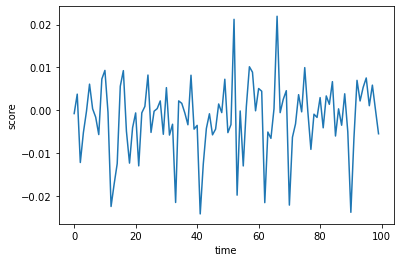

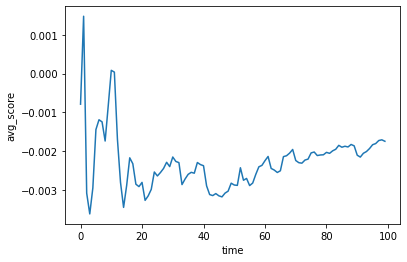

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from actor_critic import Agent
from Environment import Env
import tensorflow as tf
#from utils import plot_learning_curve

def plotData(dataToPlot,xlabel, ylabel):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(dataToPlot)
    plt.show()

type = 1   #type 0 for short term models
           #type 1 for long term models
        


if __name__ == '__main__':
  #  tf.debugging.set_log_device_placement(True)
    env = Env()
    stAgent = Agent(epsilon = 0,alpha=1e-7, n_actions=3)
    n_episodes = 100
    filename = 'bacako.png'

    figure_file = 'plots/' + filename

    best_score = env.reward_range[0]
    score_history = []
    avg_score_history = []
    load_checkpoint = True

  

    for i in range(n_episodes):

        observation = env.startState(type)
        observation_ = []
        reward = 0
        done = False
        score = 0
        while not done:
            action = stAgent.choose_action(observation[1:])

            observation_, reward, done = env.step(observation, action, type)
            #stAgent.store_transition(observation, action, reward, observation_,done)
            score += reward
            # if not load_checkpoint:
            #stAgent.learn(observation[1:], reward, observation_[1:], done)
            observation = observation_

        score_history.append(score)
       # stAgent.learn()
        avg_score = np.mean(score_history[-100:])
        avg_score_history.append(avg_score)

        """
        if avg_score > best_score:
            best_score = avg_score
            if not load_checkpoint:
                stAgent.save_models()
        """
        print('episode ' + str(i) + ' score: ' + str(score) + ' avg_score' + str(avg_score))
    plotData(score_history, "time", "score")
    plotData(avg_score_history, "time", "avg_score")
    #if not load_checkpoint:
     #   x = [i+1 for i in range(n_episodes)]
      #  plot_learning_curve(x, score_history, figure_file)

